In [57]:
import subprocess
subprocess.run(["sudo","cpupower","frequency-set","-u","6.0GHz"],stdout=subprocess.DEVNULL,stderr=subprocess.DEVNULL)

CompletedProcess(args=['sudo', 'cpupower', 'frequency-set', '-u', '6.0GHz'], returncode=0)

In [58]:
import pandas as pd
import torch.nn as nn
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [59]:
if torch.cuda.is_available():
    device="cuda"
    torch.set_default_device('cuda')

In [60]:
df=pd.read_csv("https://raw.githubusercontent.com/Arannamoy/datasets/refs/heads/main/Medical%20Cost%20Personal%20Datasets/insurance.csv")

In [61]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [62]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [64]:
categorical_cols=['sex','smoker','region']
label_encoder={}
train_df,test_df=train_test_split(df,test_size=0.25,random_state=42)
for col in categorical_cols:
    le=LabelEncoder()
    train_df[col]=le.fit_transform(train_df[col].astype(str))
    test_df[col]=le.transform(test_df[col].astype(str))
    label_encoder[col]=le

In [65]:
print(label_encoder['sex'].classes_)
print(label_encoder['region'].classes_)
print(label_encoder['smoker'].classes_)



for col,item in label_encoder.items():
    print(col,item.classes_)

    for index,label in enumerate(item.classes_):
        print(index,label)
        print(label_encoder[col].inverse_transform([index]))

['female' 'male']
['northeast' 'northwest' 'southeast' 'southwest']
['no' 'yes']
sex ['female' 'male']
0 female
['female']
1 male
['male']
smoker ['no' 'yes']
0 no
['no']
1 yes
['yes']
region ['northeast' 'northwest' 'southeast' 'southwest']
0 northeast
['northeast']
1 northwest
['northwest']
2 southeast
['southeast']
3 southwest
['southwest']


In [66]:
print(type(train_df))

<class 'pandas.core.frame.DataFrame'>


In [67]:
X_train_df=train_df.drop(columns=['charges'])
X_test_df=test_df.drop(columns=['charges'])
y_train_df=train_df['charges']
y_test_df=test_df['charges']

In [68]:
X_train_df

,age,sex,bmi,children,smoker,region
693,24,1,23.655,0,0,1
1297,28,0,26.510,2,0,2
634,51,1,39.700,1,0,3
1022,47,1,36.080,1,1,2
178,46,0,28.900,2,0,3
...,...,...,...,...,...,...
1095,18,0,31.350,4,0,0
1130,39,0,23.870,5,0,2
1294,58,1,25.175,0,0,0
860,37,0,47.600,2,1,3


In [69]:
class SimpleNNLinearRegression(nn.Module):
    def __init__(self, input_layer,hidden_layer,output_layer):
        super(SimpleNNLinearRegression,self).__init__()
        self.network=nn.Sequential(
            
            nn.Linear(input_layer,hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer,output_layer),
            nn.ReLU(),
            nn.Linear(output_layer,1)
        
        )
    def forward(self,x):
        return self.network(x)

In [70]:
scaler_X=StandardScaler()
scaler_Y=StandardScaler()
X_train_scaler=scaler_X.fit_transform(X_train_df)
X_test_scaler=scaler_X.transform(X_test_df)
y_train_scaler=scaler_Y.fit_transform(y_train_df.values.reshape(-1,1))
y_test_scaler=scaler_Y.transform(y_test_df.values.reshape(-1,1))
X_train_tensor=torch.tensor(X_train_scaler,dtype=torch.float32)
X_test_tensor=torch.tensor(X_test_scaler,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_scaler,dtype=torch.float32).view(-1,1)
y_test_tensor=torch.tensor(y_test_scaler,dtype=torch.float32).view(-1,1) ### it based on nn.linear(output_layer,1), here is 1 final neuron so 1 column.

In [71]:
print(type(X_train_tensor.shape[1]))

<class 'int'>


In [72]:
model=SimpleNNLinearRegression(X_train_tensor.shape[1],64,128)

In [73]:
criterion=nn.MSELoss()
lr=0.00001
optimizer=optim.Adam(model.parameters(),lr=lr)

In [74]:
epochs=50000
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()


    optimizer.zero_grad()

    train_pred = model(X_train_tensor)
    train_loss = criterion(train_pred, y_train_tensor)
    
    result=model(X_train_tensor)
    loss=criterion(result,y_train_tensor)
    loss.backward()
    optimizer.step()
    
    model.eval() 
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
    if (epoch + 1) % 100 == 0:
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

    if (epoch+1)%10000==0:
        print(f"epoch {epoch}/{epochs}, Loss: {loss.item()}")

epoch 9999/50000, Loss: 0.12244259566068649
epoch 19999/50000, Loss: 0.07323490083217621
epoch 29999/50000, Loss: 0.03943420201539993
epoch 39999/50000, Loss: 0.021134763956069946
epoch 49999/50000, Loss: 0.011450263671576977


In [75]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [77]:
model.eval()
y_pred=model(X_test_tensor).detach().numpy()
mse=mean_squared_error(y_test_tensor,y_pred)
print(mse)

0.33369049429893494


In [78]:
def predict_charges(age,sex,bmi,children,smoker,region):

    input_df=pd.DataFrame([[age,sex,bmi,children,smoker,region]],columns=['age','sex','bmi','children','smoker','region'])
    print(input_df)
    for col in categorical_cols:
        input_df[col]=label_encoder[col].transform(input_df[col])
    print(input_df)
    input_df=scaler_X.transform(input_df)
    input_df_tensor=torch.tensor(input_df,dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        prediction_scaled = model(input_df_tensor).numpy()
    actual_charge = scaler_Y.inverse_transform(prediction_scaled.reshape(-1, 1))
    print(actual_charge)

In [79]:
predict_charges(19,'female',27.9,0,"yes","southwest")
predict_charges(60,'female',27.9,0,"yes","southwest")

   age     sex   bmi  children smoker     region
0   19  female  27.9         0    yes  southwest
   age  sex   bmi  children  smoker  region
0   19    0  27.9         0       1       3
[[16957.764]]
   age     sex   bmi  children smoker     region
0   60  female  27.9         0    yes  southwest
   age  sex   bmi  children  smoker  region
0   60    0  27.9         0       1       3
[[42270.215]]


In [80]:
df.head(1)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.924


In [81]:
predict_charges(27,"female",27,0,'no','southwest')

   age     sex  bmi  children smoker     region
0   27  female   27         0     no  southwest
   age  sex  bmi  children  smoker  region
0   27    0   27         0       0       3
[[13847.972]]


In [82]:
import matplotlib.pyplot as plt

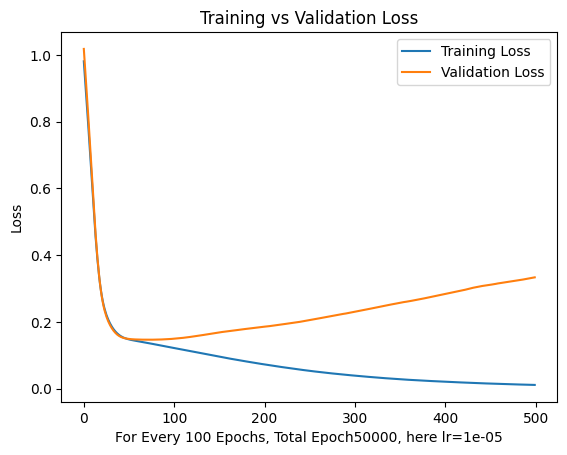

In [83]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel(f'For Every 100 Epochs, Total Epoch{epochs}, here lr={lr}')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.savefig("rate1.png")
plt.show()

In [84]:
subprocess.run(["sudo","cpupower","frequency-set","-u","2.8GHz"],stdout=subprocess.DEVNULL,stderr=subprocess.DEVNULL)

CompletedProcess(args=['sudo', 'cpupower', 'frequency-set', '-u', '2.8GHz'], returncode=0)